In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import logging

SCRIPT_NAME = "0_MMD_SIT_W2D2_WineQuality"

### Initial setup

In [2]:
import os

# setup logging
LOGGING_LEVEL = 35
logging.basicConfig(filename=f'{SCRIPT_NAME}.log', level=LOGGING_LEVEL)

def log(text: str) -> None:
    logging.log(LOGGING_LEVEL, text)

# define useful paths
BASE_PATH = '..'

IMAGE_FOLDER = os.path.join(BASE_PATH, 'reports', 'figures')

MODEL_FOLDER = os.path.join(BASE_PATH, 'models')

## Read Data

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, 'data', 'raw', 'winequality-red.csv'), sep=';')

In [4]:
Y_FEAUTURE = ['quality']
# i sort features to have strict order
X_FEATURES = sorted(list(set(df.columns) - set(Y_FEAUTURE)))
print(f"Target:\n\t{Y_FEAUTURE}\n\nFeatures:\n\t{X_FEATURES}")

Target:
	['quality']

Features:
	['alcohol', 'chlorides', 'citric acid', 'density', 'fixed acidity', 'free sulfur dioxide', 'pH', 'residual sugar', 'sulphates', 'total sulfur dioxide', 'volatile acidity']


In [5]:
log(f"read {len(df)} samples")

## Prepare Test set

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
print(f"Initial shape of dataset:\n\t{df.shape}")
dup = df.duplicated(keep='first')
print(f"count of duplicated rows:\n\t{dup.sum()}")
df = df[np.logical_not(dup.values)]
print(f"new shape of dataset:\n\t{df.shape}")
train, test = train_test_split(df, random_state=42, test_size=0.2)
log(f"train shape:\t{train.shape}\ntest shape:\t{test.shape}")

Initial shape of dataset:
	(1599, 12)
count of duplicated rows:
	240
new shape of dataset:
	(1359, 12)


## Some Data exploration

In [8]:
import seaborn as sns

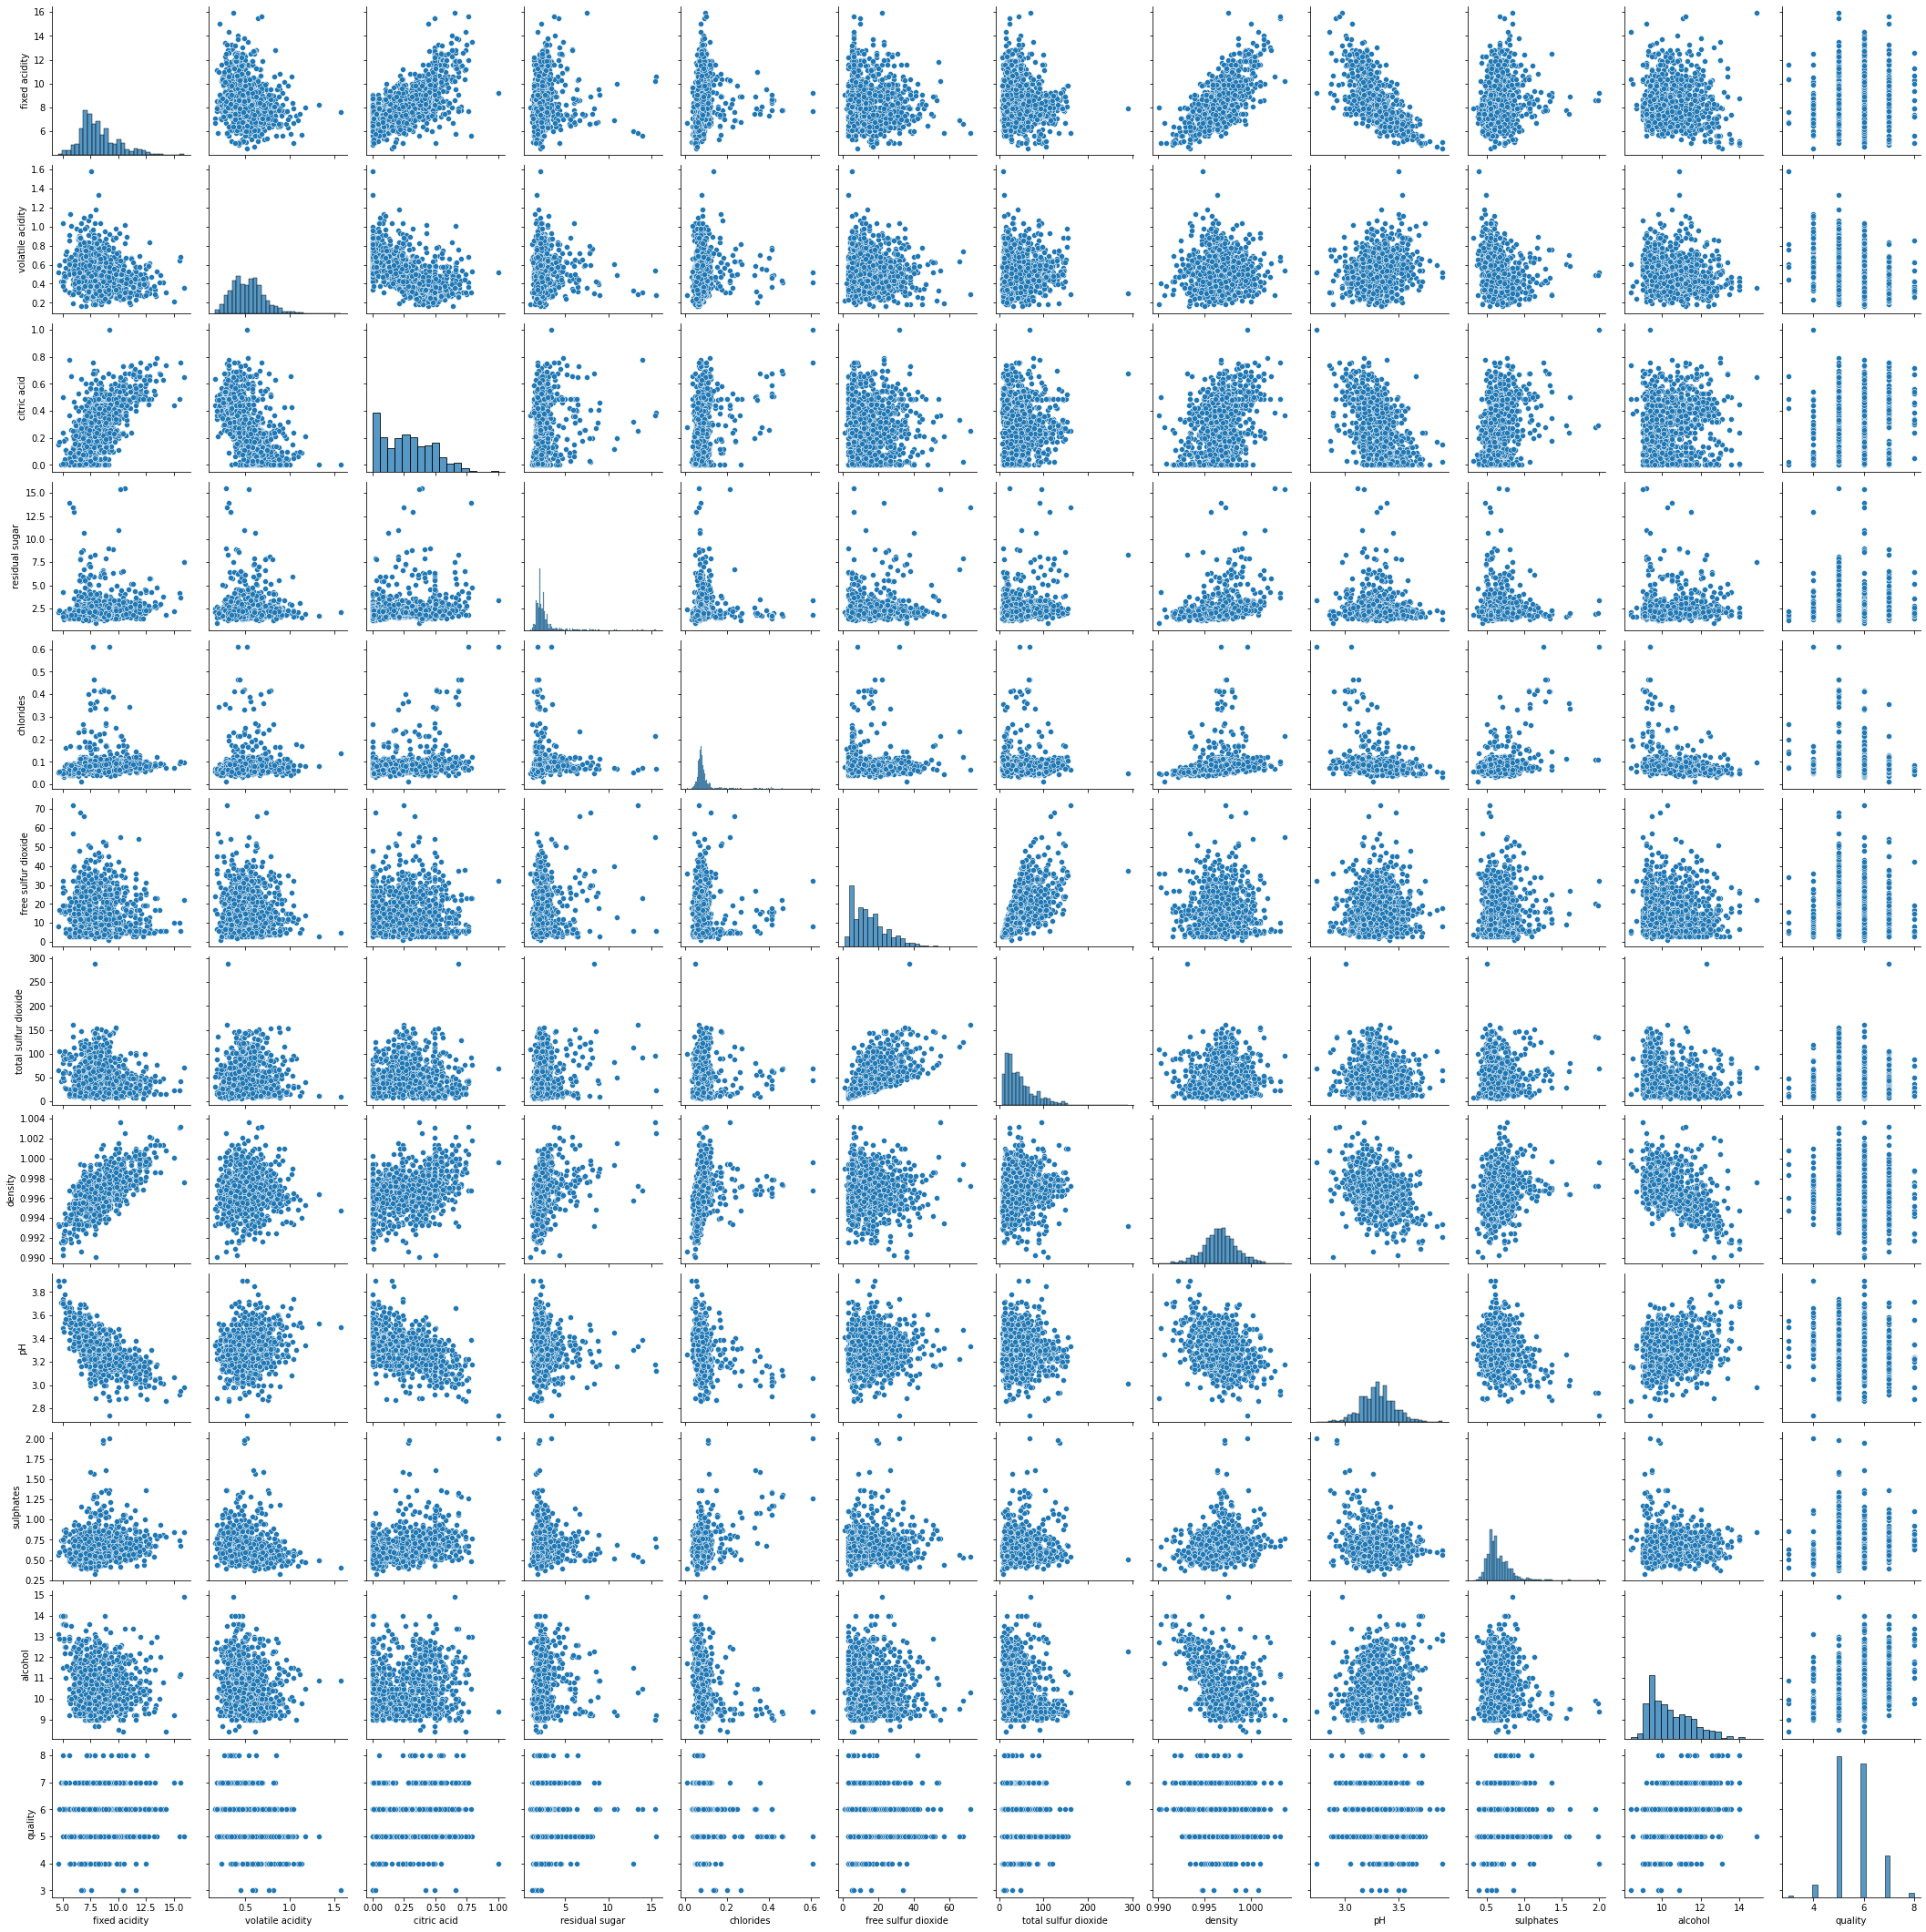

In [9]:
sns.pairplot(train)
plt.savefig(os.path.join(IMAGE_FOLDER, 'pair-plot.png'))

### Outliers detection

Let's count number of samples with some features as outliers

Number of outliers per feature:
alcohol:	11
chlorides:	75
citric acid:	1
density:	28
fixed acidity:	39
free sulfur dioxide:	20
pH:	22
residual sugar:	94
sulphates:	46
total sulfur dioxide:	36
volatile acidity:	12

Number of samples with feature ouliers:


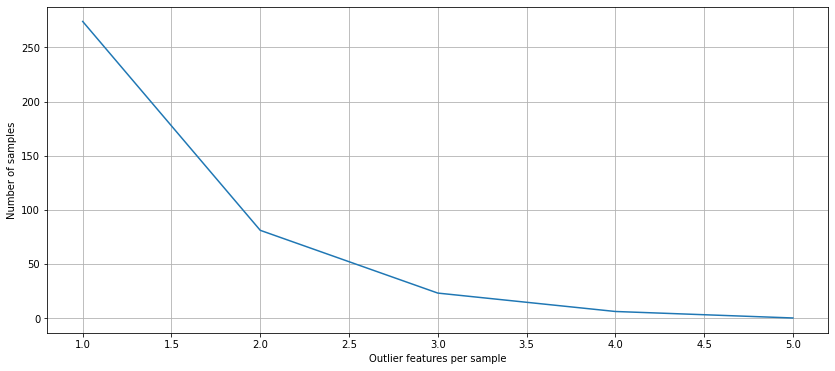

In [10]:
ouliers_total = np.zeros(len(train))

print(f"Number of outliers per feature:")
for feature in X_FEATURES:
    q1 = train[feature].describe().loc['25%']
    q3 = train[feature].describe().loc['75%']
    dist = q3 - q1
    
    temp = np.logical_or(train[feature] > q3 + 1.5 * dist, train[feature] < q1 - 1.5 * dist)
    ouliers_total += temp
    
    print(f"{feature}:\t{temp.sum()}")    
    
print(f"\nNumber of samples with feature ouliers:")
plt.figure(figsize=(14, 6))
ouliers_per_feature = [(ouliers_total >= x).sum() for x in range(1, 6)]
plt.plot(range(1, 6), ouliers_per_feature)
plt.ylabel('Number of samples')
plt.xlabel("Outlier features per sample")
plt.grid(':')
plt.savefig(os.path.join(IMAGE_FOLDER, 'outliers-per-feature.png'))

In [11]:
log(f"outliers: {len(train[ouliers_total >= 3])} samples will be dropped")

In [12]:
# remove outliers
train = train[ouliers_total < 3]

In [13]:
print(f"Finaly shape of train dataset: {train.shape}")
log(f"Finaly shape of train dataset: {train.shape}")

Finaly shape of train dataset: (1064, 12)


In [14]:
log(f"final shape of train dataset is : {train.shape}")

## Model building

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
import autosklearn.regression
import PipelineProfiler

/data/Education/SIT/DataSceince/pyenv/lib/python3.8/site-packages/pyparsing.py:3190: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


Unfortunately, I had trouble with `autosklearn`, joblib it dumped and loaded this model from inside the jupyter-notebook, but couldn't be loaded from flask script (I googled this error a lot, but I think the problem is with a dump of `autoregression`).

So, as this won't affect this assignment, I will use the usual Linear Regression.

In [17]:
from sklearn.linear_model import LinearRegression

In [18]:
%%time

regression = LinearRegression()

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 14.8 µs


In [19]:
%%time

regression.fit(train[X_FEATURES], train[Y_FEAUTURE])

CPU times: user 12.1 ms, sys: 109 µs, total: 12.2 ms
Wall time: 10.2 ms


LinearRegression()

In [20]:
y_pred = regression.predict(test[X_FEATURES])
y_train_pred = regression.predict(train[X_FEATURES])

print(
    f'Test set error (RMSE):\n\t{round(mean_squared_error(test[Y_FEAUTURE], y_pred, squared=False), 3)}\n'
    f'Train set error (RMSE):\n\t{round(mean_squared_error(train[Y_FEAUTURE], y_train_pred, squared=False), 3)}\n'
)

Test set error (RMSE):
	0.654
Train set error (RMSE):
	0.651



In [21]:
log(
    f'Test set error (RMSE):\t{round(mean_squared_error(test[Y_FEAUTURE], y_pred, squared=False), 3)}\n'
    f'Train set error (RMSE):\t{round(mean_squared_error(train[Y_FEAUTURE], y_train_pred, squared=False), 3)}\n'
)

## Dump model

In [22]:
import joblib

In [23]:
joblib.dump(regression, open(os.path.join(MODEL_FOLDER, 'regression_model'), 'wb'))

## Model explanation

In [24]:
import shap

In [25]:
# create kernel explaner object
explainer = shap.KernelExplainer(
    model=regression.predict, 
    data=test[X_FEATURES][:40], 
    link = "identity"
)

In [28]:
idx = 22

shap_value_single = explainer.shap_values(
    X=test[X_FEATURES].iloc[idx], 
    nsamples=100,
)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_value_single[0],
    features=test[X_FEATURES].iloc[idx],
)

In [29]:
shap.initjs()
shap_value = explainer.shap_values(
    X=test[X_FEATURES], 
    nsamples=100,
)

  0%|          | 0/272 [00:00<?, ?it/s]

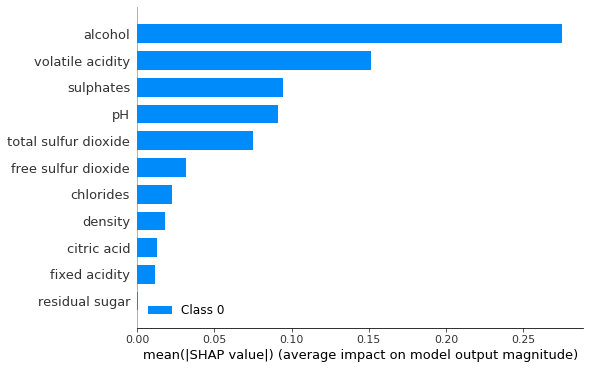

In [30]:
shap.summary_plot(
    shap_values=shap_value,
    features=test[X_FEATURES],
)